In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import pygame
import random
from collections import deque

# See environment
Just sample a random game and view the results

In [2]:
# Create the environment
env = gym.make('CartPole-v1', render_mode="human")

# Reset the environment to get the initial state
state = env.reset()

# Run a random policy for a few episodes
for episode in range(5):
    state, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        env.render()  # Render the environment

        # Take a random action
        action = env.action_space.sample()

        # Step the environment with the chosen action
        state, reward, done, truncated, info = env.step(action)
        total_reward += reward

        if done or truncated:
            break

    print(f"Episode {episode + 1}: Total Reward: {total_reward}")

env.close()

Episode 1: Total Reward: 10.0
Episode 2: Total Reward: 29.0
Episode 3: Total Reward: 24.0
Episode 4: Total Reward: 9.0
Episode 5: Total Reward: 13.0


# Create a replay buffer
The replay buffer stores previous experiences like, states, actions, rewards, next states and if the simulation ended (dones)

In [3]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed=42, device='cpu'):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.device = device

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (
            torch.tensor(states, dtype=torch.float32, device=self.device),
            torch.tensor(actions, dtype=torch.int64, device=self.device),
            torch.tensor(rewards, dtype=torch.float32, device=self.device),
            torch.tensor(next_states, dtype=torch.float32, device=self.device),
            torch.tensor(dones, dtype=torch.uint8, device=self.device)
        )

    def __len__(self):
        return len(self.memory)


# Create Q-Network
Lets start by adding a simple Q-network

In [4]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=42, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create an agent
Lets create an agent that can be trained.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [32]:
class DQNAgent:
    def __init__(self, state_size, action_size,hidden_size=512, seed=42):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, hidden_size=hidden_size, dropout=0.0).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, hidden_size=hidden_size, dropout=0.0).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=1e-4)
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.99)


        # Replay memory
        self.memory = ReplayBuffer(buffer_size=int(1e5), batch_size=64, seed=seed, device=device)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory) > self.memory.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)

    def act(self, state, eps=0.):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards.unsqueeze(1) + (gamma * Q_targets_next * (1 - dones).unsqueeze(1))

        Q_expected = self.qnetwork_local(states).gather(1, actions.unsqueeze(1))

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 2.42)
        self.optimizer.step()
        self.scheduler.step()  # Step the scheduler

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


# Create a saw-tooth like exploration
Lets not simply decay the explore part, lets cycle it

In [47]:
def sawtooth_eps_decay(episode, peak_eps=1.0, min_eps=0.01, period=50, decay_factor=0.995):
    """
    Calculate the epsilon value in a sawtooth pattern with a shrinking envelope.
    
    Parameters:
        episode (int): Current episode number.
        peak_eps (float): Initial peak epsilon value.
        min_eps (float): Minimum epsilon value.
        period (int): Number of episodes for one complete up-down cycle.
        decay_factor (float): Factor by which the peak epsilon value decays after each period.
        
    Returns:
        float: Calculated epsilon value.
    """
    # cycle = episode // period
    # cycle_position = episode % period
    # current_peak_eps = peak_eps * (decay_factor ** cycle)
    
    # if current_peak_eps < min_eps:
    #     current_peak_eps = min_eps
    
    # eps = current_peak_eps - (current_peak_eps - min_eps) * (cycle_position / period)
    cycle = episode // period
    cycle_position = episode % period
    current_peak_eps = peak_eps * (decay_factor ** cycle)

    if current_peak_eps < min_eps:
        current_peak_eps = min_eps

    half_period = period // 2
    if cycle_position < half_period:
        # Decrease epsilon
        eps = current_peak_eps - (current_peak_eps - min_eps) * (cycle_position / half_period)
    else:
        # Increase epsilon
        eps = min_eps + (current_peak_eps - min_eps) * ((cycle_position - half_period) / half_period)
    
    return eps

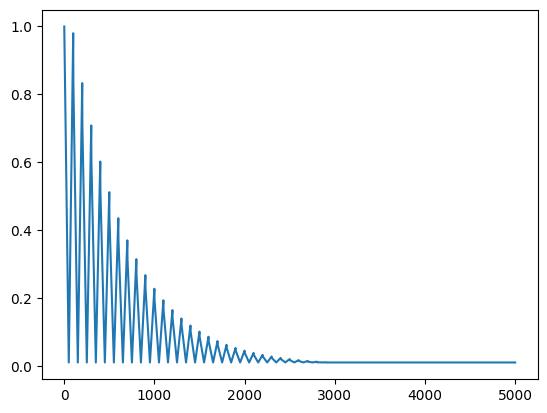

In [46]:
epsilons = [sawtooth_eps_decay(episode, decay_factor = 0.85, period=100) for episode in range(5000)]
plt.plot(epsilons)

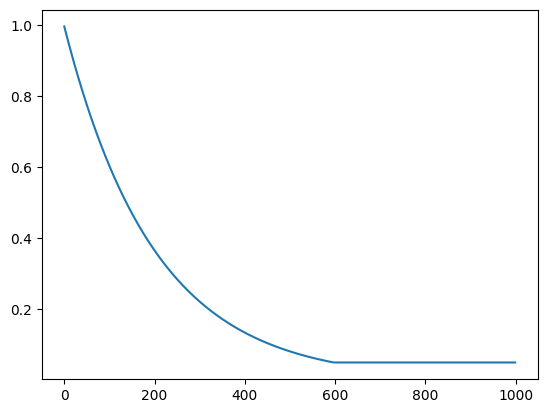

In [43]:
# Test the alternative epsilon decay function
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.995
epsilons = []
eps = eps_start
for i in range(1000):
    eps = max(eps_end, eps_decay * eps)
    epsilons.append(eps)
plt.plot(epsilons)

In [49]:
#env_name = 'CartPole-v0' #Max episode length is 200
env_name = 'CartPole-v1' #Max episode length is 500
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, hidden_size=1024, seed=42)


In [50]:


n_episodes = 10000
max_t = 500
eps_start = 1.0
eps_end = 0.03
eps_decay = 0.85
eps_period = 100

scores = []
scores_window = deque(maxlen=100)
eps = eps_start
for i_episode in range(1, n_episodes + 1):
    state, info = env.reset()
    score = 0
    eps = sawtooth_eps_decay(i_episode, peak_eps=eps_start, min_eps=eps_end, period=eps_period, decay_factor=eps_decay)
    for t in range(max_t):
        action = agent.act(state, eps)
        next_state, reward, done, truncated, info = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        #print(f"Episode {i_episode}\tTimestep {t}\tScore: {score:.2f} \treward: {reward}")
        if done:
            break
    scores_window.append(score)
    scores.append(score)
    #eps = max(eps_end, eps_decay * eps)

    print(f"Episode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\teps: {eps:.2f}\tlr: {agent.scheduler.get_last_lr()[0]:.6f}")

    if np.mean(scores_window) >= 500*0.9:
        print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break

#env.close()

Episode 1	Average Score: 11.00	eps: 0.98	lr: 0.000100
Episode 2	Average Score: 15.50	eps: 0.96	lr: 0.000100
Episode 3	Average Score: 16.67	eps: 0.94	lr: 0.000100
Episode 4	Average Score: 17.00	eps: 0.92	lr: 0.000100
Episode 5	Average Score: 19.60	eps: 0.90	lr: 0.000100
Episode 6	Average Score: 20.17	eps: 0.88	lr: 0.000100
Episode 7	Average Score: 18.86	eps: 0.86	lr: 0.000100
Episode 8	Average Score: 19.62	eps: 0.84	lr: 0.000100
Episode 9	Average Score: 19.33	eps: 0.83	lr: 0.000100
Episode 10	Average Score: 19.90	eps: 0.81	lr: 0.000100
Episode 11	Average Score: 20.00	eps: 0.79	lr: 0.000100
Episode 12	Average Score: 19.33	eps: 0.77	lr: 0.000100
Episode 13	Average Score: 20.08	eps: 0.75	lr: 0.000100
Episode 14	Average Score: 19.50	eps: 0.73	lr: 0.000100
Episode 15	Average Score: 18.93	eps: 0.71	lr: 0.000100
Episode 16	Average Score: 19.25	eps: 0.69	lr: 0.000100
Episode 17	Average Score: 19.18	eps: 0.67	lr: 0.000100
Episode 18	Average Score: 19.06	eps: 0.65	lr: 0.000100
Episode 19	Average 

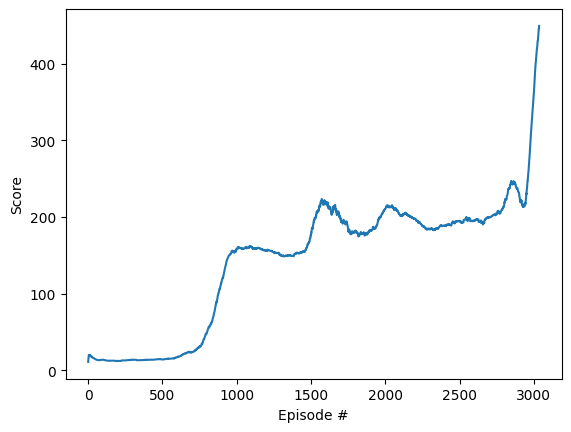

In [51]:
# plot the scores
# rolling average scores
rolling_average = [np.mean(scores[max(0, i-100):i+1]) for i in range(len(scores))]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rolling_average)), rolling_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [52]:
def visualize_agent(agent, env, n_episodes=5):
    for i_episode in range(1, n_episodes + 1):
        state, info = env.reset()
        done = False
        score = 0
        max_t = 500
        t = 0
        while not done:
            env.render()
            action = agent.act(state)
            next_state, reward, done, truncated, info = env.step(action)
            state = next_state
            score += reward
            t += 1
            if done or t >= max_t:
                break
        print(f"Episode {i_episode}\tScore: {score}")
    env.close()

In [54]:
# Visualize the agent
#env.render_mode = "human"
env = gym.make('CartPole-v1', render_mode="human")
visualize_agent(agent, env)

Episode 1	Score: 500.0
Episode 2	Score: 500.0
Episode 3	Score: 500.0
Episode 4	Score: 500.0
Episode 5	Score: 500.0
